# Resize Images from google images to 224x224

In [1]:
# import os 
# import numpy as np
# import cv2

# downloadsdir = './downloads'
# dirs = [x for x in os.walk(downloadsdir)]
# for shroom in dirs[0][1]:
#     resizeddir = './resized\\\\'+shroom
#     fullsizedir = './downloads\\\\'+shroom
#     if not os.path.exists(resizeddir):
#         os.makedirs(resizeddir)
#     pics = [x[2] for x in os.walk(fullsizedir)]
#     for idx, p in enumerate(pics[0]):
#         if not p.endswith('.gif'):
#             picpath = fullsizedir+'\\\\'+p
#             try:
#                 img = cv2.imread(picpath,-1)
#                 resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
#                 cv2.imwrite(resizeddir+'\\\\'+str(idx)+'.jpg', resized)
#             except:
#                 print('Could not process ' + p)


In [2]:
import pandas as pd
import numpy as np
import os
import cv2

num_classes = 16

X = []
y = []
# is_edible = []

# mushroom_info = pd.read_json('mushroom_classes.json', lines=True)
classdirs = [x for x in os.walk('./resized')]
for shroomidx, shroom in enumerate(classdirs[0][1]):
#     info = mushroom_info.loc[mushroom_info.name_latin == shroom]
#     edible = info.edibility.isin(("edible", "edible and good", "edible and excellent"))
#     is_edible.append(edible)
    imagepaths = [x for x in os.walk('./resized\\\\'+shroom)]
    for path in imagepaths[0][2]:
        img = cv2.imread('./resized\\\\'+shroom+'\\\\'+path,-1)
        if (img.shape == (224, 224, 3)):
            X.append(img)
            y.append(shroomidx)

X = np.stack(X)
y = np.stack(y)
# is_edible = pd.Series(is_edible)
print(X.shape)
print(y.shape)
# print(is_edible.shape)
    

(1090, 224, 224, 3)
(1090,)


In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator()

C:\Users\Kevin\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# Train and test data
import keras
# rescale !!
X = X/255.0

N = len(X)
N_tr = int(0.8*N)

# shuffle the data
indx = np.arange(N)
np.random.shuffle(indx)
X = X[indx]
y = y[indx]

# split
X_tr = X[0:N_tr]
y_tr = y[0:N_tr]
y_tr = keras.utils.to_categorical(y_tr, num_classes)

X_te = X[N_tr:]
y_te = y[N_tr:]
y_te = keras.utils.to_categorical(y_te, num_classes)


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

def my_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=X[0].shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='sigmoid'))
    return model



In [6]:
model = my_model()


from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau

# basemodel = VGG16(include_top=False,
#                   input_shape=(224,224,3))
# # for layer in basemodel.layers[1:13]:
# #     layer.trainable = False
    
# topmodel = Sequential()
# topmodel.add(Flatten(input_shape=basemodel.output_shape[1:]))
# topmodel.add(Dense(num_classes, activation='relu'))
# topmodel.add(Dropout(0.4))
# topmodel.add(Dense(num_classes, activation='sigmoid'))

# model = Model(inputs = basemodel.input, outputs = topmodel(basemodel.output))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(lr=0.0001),
              metrics=['accuracy'])

model_json = model.to_json()
with open("models/model.json", "w") as json_file:
    json_file.write(model_json)


In [7]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 108, 108, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 106, 106, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 53, 53, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 51, 51, 256)       295168    
__________

In [8]:
# fits the model on batches with real-time data augmentation:
N_BATCH = 16

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.75,
                              patience=3,
                              min_lr=0.00001)
history = model.fit(X_tr, y_tr,
                    batch_size = N_BATCH,
                    epochs = 200,
                    verbose = 1,
                    validation_data = (X_te, y_te),
                    callbacks=[reduce_lr])

# save model weights and training history
model.save_weights('models/weights.h5')
import pickle
with open('models/history', 'wb') as f:
        pickle.dump(history.history, f)

Train on 872 samples, validate on 218 samples
Epoch 1/200
872/872 [==============================] - 26s 30ms/step - loss: 2.7724 - acc: 0.0677 - val_loss: 2.7531 - val_acc: 0.0780
Epoch 2/200
872/872 [==============================] - 19s 22ms/step - loss: 2.7438 - acc: 0.1044 - val_loss: 2.7510 - val_acc: 0.1193
Epoch 3/200
872/872 [==============================] - 19s 22ms/step - loss: 2.7242 - acc: 0.1021 - val_loss: 2.6419 - val_acc: 0.1376
Epoch 4/200
872/872 [==============================] - 19s 22ms/step - loss: 2.7054 - acc: 0.1112 - val_loss: 2.6234 - val_acc: 0.1284
Epoch 5/200
872/872 [==============================] - 19s 22ms/step - loss: 2.6536 - acc: 0.1158 - val_loss: 2.5466 - val_acc: 0.1284
Epoch 6/200
872/872 [==============================] - 19s 22ms/step - loss: 2.6412 - acc: 0.1342 - val_loss: 2.5787 - val_acc: 0.1330
Epoch 7/200
872/872 [==============================] - 19s 22ms/step - loss: 2.6830 - acc: 0.1147 - val_loss: 2.5791 - val_acc: 0.1239
Epoch 8/2

Epoch 61/200
872/872 [==============================] - 19s 22ms/step - loss: 1.6549 - acc: 0.3899 - val_loss: 1.8358 - val_acc: 0.3761
Epoch 62/200
872/872 [==============================] - 19s 22ms/step - loss: 1.6554 - acc: 0.4002 - val_loss: 1.8109 - val_acc: 0.3991
Epoch 63/200
872/872 [==============================] - 19s 22ms/step - loss: 1.5860 - acc: 0.4174 - val_loss: 1.9622 - val_acc: 0.4083
Epoch 64/200
872/872 [==============================] - 19s 22ms/step - loss: 1.6332 - acc: 0.4197 - val_loss: 1.8648 - val_acc: 0.4037
Epoch 65/200
872/872 [==============================] - 19s 22ms/step - loss: 1.6305 - acc: 0.4255 - val_loss: 1.7927 - val_acc: 0.4220
Epoch 66/200
872/872 [==============================] - 19s 22ms/step - loss: 1.5969 - acc: 0.4232 - val_loss: 1.8181 - val_acc: 0.4083
Epoch 67/200
872/872 [==============================] - 19s 22ms/step - loss: 1.6016 - acc: 0.4048 - val_loss: 1.8815 - val_acc: 0.4404
Epoch 68/200
872/872 [==========================

872/872 [==============================] - 19s 22ms/step - loss: 1.1942 - acc: 0.5333 - val_loss: 2.1249 - val_acc: 0.5000
Epoch 122/200
872/872 [==============================] - 19s 22ms/step - loss: 1.2935 - acc: 0.5367 - val_loss: 2.0461 - val_acc: 0.4817
Epoch 123/200
872/872 [==============================] - 19s 22ms/step - loss: 1.2141 - acc: 0.5252 - val_loss: 2.0223 - val_acc: 0.4954
Epoch 124/200
872/872 [==============================] - 19s 22ms/step - loss: 1.3203 - acc: 0.5596 - val_loss: 1.9375 - val_acc: 0.5321
Epoch 125/200
872/872 [==============================] - 19s 22ms/step - loss: 1.2922 - acc: 0.5619 - val_loss: 1.9841 - val_acc: 0.4908
Epoch 126/200
872/872 [==============================] - 19s 22ms/step - loss: 1.1953 - acc: 0.5573 - val_loss: 2.0530 - val_acc: 0.4862
Epoch 127/200
872/872 [==============================] - 19s 22ms/step - loss: 1.2210 - acc: 0.5757 - val_loss: 2.0646 - val_acc: 0.5046
Epoch 128/200
872/872 [==============================] 

Epoch 181/200
872/872 [==============================] - 19s 22ms/step - loss: 1.0224 - acc: 0.6170 - val_loss: 2.2328 - val_acc: 0.5367
Epoch 182/200
872/872 [==============================] - 19s 22ms/step - loss: 1.0181 - acc: 0.6365 - val_loss: 2.2930 - val_acc: 0.5229
Epoch 183/200
872/872 [==============================] - 19s 22ms/step - loss: 1.0165 - acc: 0.6422 - val_loss: 2.2474 - val_acc: 0.5092
Epoch 184/200
872/872 [==============================] - 19s 22ms/step - loss: 0.9740 - acc: 0.6376 - val_loss: 2.3234 - val_acc: 0.5505
Epoch 185/200
872/872 [==============================] - 19s 22ms/step - loss: 1.0624 - acc: 0.6353 - val_loss: 2.2767 - val_acc: 0.5505
Epoch 186/200
872/872 [==============================] - 19s 22ms/step - loss: 0.9451 - acc: 0.6617 - val_loss: 2.3246 - val_acc: 0.5046
Epoch 187/200
872/872 [==============================] - 19s 22ms/step - loss: 0.9975 - acc: 0.6606 - val_loss: 2.2784 - val_acc: 0.5183
Epoch 188/200
872/872 [==================

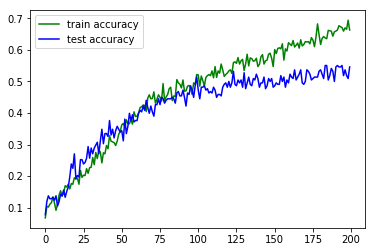

In [13]:
# load the model training history
import matplotlib.pyplot as plt
with open("models/history", "rb") as f:
    hist = pickle.load(f)
    
plt.plot(hist["acc"], label = "train accuracy", color = "green")
plt.plot(hist["val_acc"], label = "test accuracy", color = "blue")
plt.legend()
plt.savefig("docs/training_history.png")
plt.show()

In [10]:
model.save("./models/model2.h5")


In [11]:
# from keras import backend as K

# model = keras.models.load_model("./models/model2.h5")

# session = K.get_session()
# for layer in model.layers[-6:]:
#     if hasattr(layer, 'kernel_initializer'):
#         layer.kernel.initializer.run(session=session)
        
# for layer in model.layers[0:-6]:
#     layer.trainable = False
    
# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.SGD(),
#               metrics=['accuracy'])
# print(model.summary())

In [12]:
# N_BATCH = 16

# reduce_lr = ReduceLROnPlateau(monitor='val_loss',
#                               factor=0.85,
#                               patience=5,
#                               min_lr=0.001)
# history = model.fit(X_tr, y_tr,
#                     batch_size = N_BATCH,
#                     epochs = 300,
#                     verbose = 1,
#                     validation_data = (X_te, y_te),
#                     callbacks=[reduce_lr])